Although current machine learning algorithms have acquired a good reputation in terms of achieving the goals they are trained to do, they are prone to foregtting old data. If one takes a trained model and fine-tunes it on different data, its performance on the old data deteriorates. This is what the community calls **Catastrophic Forgetting**. There are many questions that rotates around this concept, but in this notebook we are going to introduce the most basic ones.

1- How the performance is affected when we train our models in a temporal fashion.

2- What are the basic remedies to avoid deterioration over time.

**Data**

First, we need to simulate a dataset that mimic the temporal nature of the problem we have in hand. One way to achieve that is splitting up already exisiting datasets into smaller sets of tasks that change over time.

To keep everything simple we will use MNIST as our source dataset and split it over 5 smaller datasets where each one recognizes 2 numbers. 


There are two ways to treat the 5 splitted tasks:


**1- Multi-head setting** 

&emsp; &emsp; Where for every single task we have a common hidden representation and a head specific to that task. When a new task comes, we use the same hidden representation and create a unique head. At test time, we should keep track of which task the test data belongs to. For example, for MNIST data, we first train the model to identify 0 & 1 images then, when the second task comes, the model fine-tunes the hidden representation and creates a new head to identify 2 & 3 images. In the previous example, the model will keep track that 2 & 3 data belong to task #2 and it will expect to receive this information at test time to acquire the right head.
This has the negative side effect of needing knowledge about what task a datapoint belongs to. This is particularly unrealistic in real-world scenarios.
 
**2- Single-head setting**

&emsp; &emsp; In this setting, one unified model shall be used across all tasks. The number of output units will grow as the number of the encountered classes increases. When known in advance, the total number of tasks can be used from the beginning. For MNIST, 10 output units will be used. Despite the fact that 0 and 2 images might not be directly compared in the same task, the model should still be capable of distinguishing them without any additional information. At test time, we can process the data whitout keeping track of what task this data occured in, which is a more realistic setting.







*The performance will be evaluated as the average accuracy over all seen tasks.*

**Using MNIST data for CL: Split MNIST benchmark**

In [1]:
# some initial imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

In [3]:
# Get MNIST data
!git clone https://github.com/ContinualAI/colab.git continualai/colab

from continualai.colab.scripts import mnist
mnist.init()

Cloning into 'continualai/colab'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 157 (delta 15), reused 24 (delta 8), pack-reused 120
Receiving objects: 100% (157/157), 10.09 MiB | 49.67 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Download complete.
Save complete.


In [4]:
# print some MNIST info
x_train, t_train, x_test, t_test = mnist.load()

print(f'Size of training data is: {t_train.shape[0]}, size of test data: {t_test.shape[0]}')

for i in range(10):
  print(f'Size of label {i} in training : {len(t_train[t_train == i])}')

Size of training data is: 60000, size of test data: 10000
Size of label 0 in training : 5923
Size of label 1 in training : 6742
Size of label 2 in training : 5958
Size of label 3 in training : 6131
Size of label 4 in training : 5842
Size of label 5 in training : 5421
Size of label 6 in training : 5918
Size of label 7 in training : 6265
Size of label 8 in training : 5851
Size of label 9 in training : 5949


*We* can start by splitting the data into 5 tasks according to their labels. Since the setting with multiple-head will always classify between two classes, we will modify the labels to be always Class 0 or Class 1. We call this `task_data_with_overlap` since the classes overlap. The single-head naturally supports 10 classes.

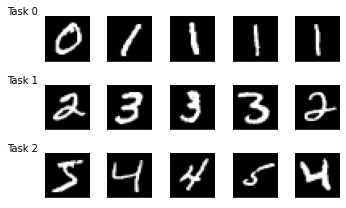

In [5]:
# tasks to use
task_classes_arr = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
tasks_num = len(task_classes_arr) # 5

task_data = []
task_data_with_overlap = []
for i, task_classes in enumerate(task_classes_arr):
  train_mask = np.isin(t_train, task_classes)
  test_mask = np.isin(t_test, task_classes)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask]
  
  task_data.append((x_train_task, t_train_task, x_test_task, t_test_task))
  task_data_with_overlap.append((x_train_task, t_train_task - (i * 2),
                                 x_test_task, t_test_task - (i * 2)))

# Display tasks
def plot_task(axs, data, samples_num):
  for sample in range(samples_num):
    axs[sample].imshow(data[sample][0], cmap="gray")
    # np.vectorize(lambda ax:ax.axis('off'))(axs[sample]);
    axs[sample].xaxis.set_ticks([])
    axs[sample].yaxis.set_ticks([])

n_tasks, samples = 3, 5
_, axs = plt.subplots(n_tasks, samples, figsize=(5, 3))
for task in range(n_tasks):
  axs[task, 0].set_ylabel(f'Task {task}', rotation=0)
  axs[task, 0].yaxis.set_label_coords(-0.5,1)
  plot_task(axs[task], task_data[task][0], samples)
plt.tight_layout()

**Naive strategy with Single Head**

We will first explore continual learning and forgetting by using a single head, 
then by using multiple heads.

The **Naive** strategy simply finetunes the model on the new data, without applying any CL strategies.

In [6]:
# A basic feedforward net
class FNet(nn.Module):
  def __init__(self, hsize=512):
    super(FNet, self).__init__()

    self.l1 = nn.Linear(784, hsize)
    self.l2 = nn.Linear(hsize, 10)
    
  def forward(self, x):
      x = x.view(x.size(0), -1)
      x = F.relu(self.l1(x))
      x = self.l2(x)
      return x

In [7]:
def train(model, device, x_train, t_train, optimizer, epochs=10, log_training=False):
    for epoch in range(epochs):
      model.train()
      
      for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        if log_training:
          print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    return test_loss, 100. * correct / len(t_test)

We will train the functions above on task 1 and fine-tune on task 2 to see how additional data affect the performance.

In [8]:
model = FNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
x_train_1, t_train_1, x_test_1, t_test_1 = task_data[0]
x_train_2, t_train_2, x_test_2, t_test_2 = task_data[1]

print('Training on Task 1')
train(model, device, x_train_1, t_train_1, optimizer, epochs=3)

loss, acc = test(model, device, x_test_1, t_test_1)
print(f'Testing on Task 1: loss -> {loss}, acc -> {acc}')

print('------------')
print('Training on Task 2')
train(model, device, x_train_2, t_train_2, optimizer, epochs=3)

loss, acc = test(model, device, x_test_1, t_test_1)
print(f'Testing on Task 1: loss -> {loss}, acc -> {acc}')
loss, acc = test(model, device, x_test_2, t_test_2)
print(f'Testing on Task 2: loss -> {loss}, acc -> {acc}')

Training on Task 1
Testing on Task 1: loss -> 1.707715103424751e-05, acc -> 99.90543735224587
------------
Training on Task 2
Testing on Task 1: loss -> 0.0674293324175174, acc -> 0.0
Testing on Task 2: loss -> 0.00029021617477571814, acc -> 97.20861900097943


As we can see, the progress we achieved on Task #1 is lost once we fine-tune to Task #2. 

In CL, we talk about **Catastrophic Forgetting**.


**Continual Learning via Rehearsal / Replay:**

One way to mitigate Catastrophic Forgetting is to keep a portion of the old data to be interleaved with the data from the current task, so that the network does not forget. An ideal scenario is to keep all the old data, however, this is not practical in real applications with memory constraints. Therefore, it is preferrable to keep a limited number of old patterns to be replayed.

In the next section we will use the Rehearsal strategy and compare it to the previously seen Naive strategy.

In [9]:
# We will use this function to shuffle the union of old data with the new task data.
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

In [10]:
# we can use this function to train the model on all tasks for a percentage of 
# old data to rehearse. 0% means naive with expected catastrophic forgetting
def train_singlehead(past_examples_percentage=0, epochs=15):
  model = FNet().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  accs_fine_grid = []
  for i in range(tasks_num):
    x_train, t_train, _, _ = task_data[i]

    # concatenate previous tasks
    for j in range(0, i + 1):
      past_x_train, past_t_train, _, _ = task_data[j]
      example_num = int(past_examples_percentage * len(past_t_train))
      x_train = np.concatenate((x_train, past_x_train[:example_num]))
      t_train = np.concatenate((t_train, past_t_train[:example_num]))

    x_train, t_train = shuffle_in_unison([x_train, t_train], 0)
    train(model, device, x_train, t_train, optimizer, epochs)

    # test on tasks seen so far
    accs_subset = []
    for j in range(0, i + 1):
      _, _, x_test, t_test = task_data[j]
      _, test_acc = test(model, device, x_test, t_test)
      accs_subset.append(test_acc)
    
    if i < (tasks_num - 1):
      accs_subset.extend([np.nan] * (4 - i))

    accs_fine_grid.append(accs_subset)

  return accs_fine_grid



In [11]:
accs_naive = train_singlehead() # naive: 0%
accs_rehearsal_all = train_singlehead(1) # regural supervised fashion: 100% 
accs_rehearsal_5 = train_singlehead(0.05) # 5%, about 100 example per task

Text(0.5, 24.0, 'Task Number')

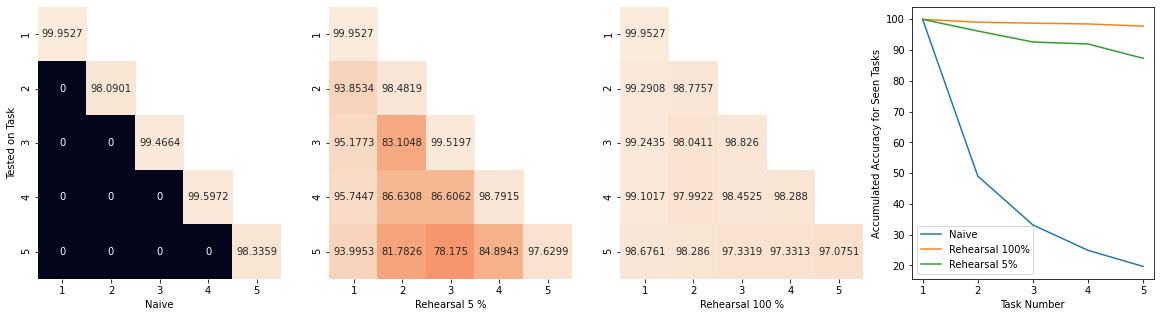

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
accs_fine_grid = np.array(accs_naive)
nan_mask = np.isnan(accs_naive)

sns.heatmap(accs_naive, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[0], cbar=False)
sns.heatmap(accs_rehearsal_5, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[1], cbar=False)
sns.heatmap(accs_rehearsal_all, vmin=0, vmax=100, mask=nan_mask, annot=True,  fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[2], cbar=False)

axes[0].set_ylabel('Tested on Task')

axes[0].set_xlabel('Naive')
axes[1].set_xlabel('Rehearsal 5 %')
axes[2].set_xlabel('Rehearsal 100 %')


axes[3].plot(range(1, 6), np.nanmean(accs_naive, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_all, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_5, axis=1))
axes[3].legend(['Naive', 'Rehearsal 100%', 'Rehearsal 5%'])
axes[3].set_ylabel('Accumulated Accuracy for Seen Tasks')
axes[3].set_xlabel('Task Number')

In the above graph, we saw that accuracy improves by adding 5% of previous data (~50 example per class). Even if forgetting is not completely defeated, it definitely is a step forward from the Naive strategy.

**Multi-Head setting**

In the following section we will move to the multi-head setting and reproduce what we have done with the single-head setting. We will create a `BaseNet` that holds the shared hidden representation to be fine-tuned and a `HeadNet` which holds the separate heads for every task and takes the shared representation as an input. At test time, there will be an oracle that informs us of the task from which each data-point comes from. 



In [13]:
class FBaseNet(nn.Module):
  def __init__(self, hsize=512):
    super(FBaseNet, self).__init__()
    self.l1 = nn.Linear(784, hsize)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.relu(self.l1(x))
    return x


class FHeadNet(nn.Module):
  def __init__(self, base_net, input_size=512):
    super(FHeadNet, self).__init__()

    self.base_net = base_net

    self.l1 = nn.Linear(input_size, 2)

  def forward(self, x):
    x = self.base_net.forward(x)
    x = self.l1(x)
    return x

In [14]:
def train_multihead(past_examples_percentage=0, epochs=15):
  base = FBaseNet().to(device)
  heads = []

  accs_fine_grid = []

  for i in range(tasks_num):
    x_train, t_train, _, _ = task_data_with_overlap[i]
    model = FHeadNet(base).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    heads.append(model)

    # concatenate previous tasks
    for j in range(0, i + 1):
      past_x_train, past_t_train, _, _ = task_data_with_overlap[j]
      example_num = int(past_examples_percentage * len(past_t_train))
      x_train = np.concatenate((x_train, past_x_train[:example_num]))
      t_train = np.concatenate((t_train, past_t_train[:example_num]))

    x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

    train(model, device, x_train, t_train, optimizer, epochs)
    # test on tasks seen so far
    accs_subset = []
    for j in range(0, i + 1):
      _, _, x_test, t_test = task_data_with_overlap[j]
      _, test_acc = test(heads[j], device, x_test, t_test)
      accs_subset.append(test_acc)

    if i < (tasks_num - 1):
      accs_subset.extend([np.nan] * (4 - i))
    
    accs_fine_grid.append(accs_subset)

  return accs_fine_grid


In [15]:
accs_naive = train_multihead(epochs=15)
accs_rehearsal_all = train_multihead(1, epochs=15)
accs_rehearsal_5 = train_multihead(0.05, epochs=15)

Text(0.5, 24.0, 'Task Number')

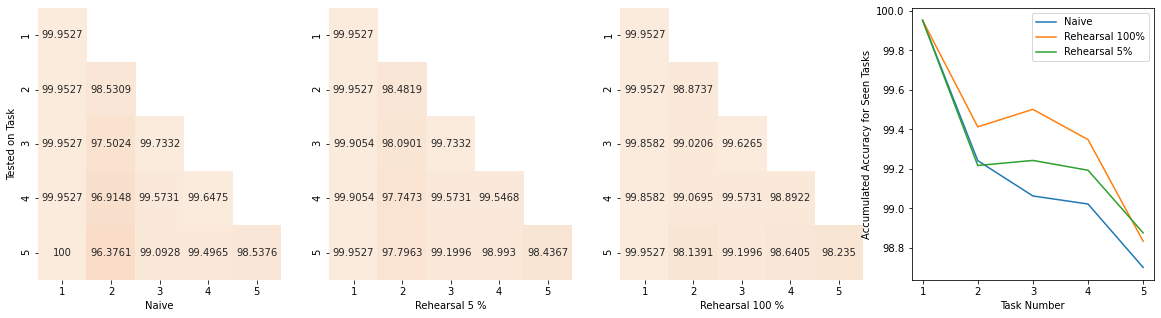

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
accs_fine_grid = np.array(accs_fine_grid)

nan_mask = np.isnan(accs_fine_grid)

sns.heatmap(accs_naive, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[0], cbar=False)
sns.heatmap(accs_rehearsal_5, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[1], cbar=False)
sns.heatmap(accs_rehearsal_all, vmin=0, vmax=100, mask=nan_mask, annot=True,  fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[2], cbar=False)

axes[0].set_ylabel('Tested on Task')

axes[0].set_xlabel('Naive')
axes[1].set_xlabel('Rehearsal 5 %')
axes[2].set_xlabel('Rehearsal 100 %')


axes[3].plot(range(1, 6), np.nanmean(accs_naive, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_all, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_5, axis=1))

axes[3].legend(['Naive', 'Rehearsal 100%', 'Rehearsal 5%'])
axes[3].set_ylabel('Accumulated Accuracy for Seen Tasks')
axes[3].set_xlabel('Task Number')


With the multi-head setting all the strategies maintains a good performance on previous tasks, especially using a simple network. This highlights the unrealistic assumptions behind Multi-Head, which is able to tackle catastrophic forgetting effectively even without any CL strategy. As we already explained, however, multi-head setting is a very unrealistic CL scenario.